# Discovering Techniques of Pro Scrabble Players
## An in-depth analysis of the most useful tips for an ameture player

Scrabble is a popular word game in which two to four players score points by placing tiles, each bearing a single letter, onto a game board divided into a 15×15 grid of squares. The tiles must form words that, in crossword fashion, read left to right in rows or downward in columns and are included in a standard dictionary or lexicon.<br>
This game is known to many as a fun way to spend time with family and friends, while challenging your knowledge and mastery of the english language. It may then surprise you to learn that there are sizable proffesional scrabble tournaments held all over the world. On the pro level the game is a lot more than a fun pastime; players have an incredibly impressive vocabulary and calculate their plays based on unseen tiles, limiting their oppenents' opportunities, and anticipating effective letter combinations. At this level, based on the games collected here there are an average of **nearly 4 Bingos** (a turn when a player uses all 7 letters from his rack) per game!<br>
With the help of publicly posted Pro Scrabble games on [cross-tables.com](cross-tables.com), I was able to collect 1,000 of these games and conduct an analysis into the play style of the pros. I looked for insightful trends and tactics that could help an ameture Scrabble player step up their game. For example, I collected a database of the most popular words played, with helpful tools and filters that help you adjust for specific letters and word lengths.<br><br>
Below is a short overview of the analyses included in this project:
- Premium squares effectiveness
- Individual letter analysis
- Analyzing the most popular squares for each letter
- Finding the most played words
- Visualizing scoring trends

## Building the Dataset 
### Creating Preset Functions, Lists and Dictionaries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import ipywidgets as widgets
import math
import requests
from itables import init_notebook_mode, show
init_notebook_mode(all_interactive=False)
init_notebook_mode(connected=True)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

<IPython.core.display.Javascript object>

We'll begin by creating two lists, one with the first 15 numbers (the length of the board) and one with all uppercase letters for easy access in the future.

In [2]:
from string import ascii_uppercase, ascii_lowercase
numbers = []
for i in range(16):
    numbers.append(i)
letters = []
for l in ascii_uppercase:
    letters.append(l)
playable_tiles = letters + ['Blank']

The following two dictionaries will contain all squares on the board with extra point tiles and a tally of all tile types.

In [3]:
special_spots = {'2LS': ['1D', '1L', '3G', '3I', '4A', '4H', '4O', '7C', '7G', '7I', '7M', '8D', '8L', '9C', '9G', '9I', '9M', '12A', '12H', '12O', '13G', '13I', '15D', '15L'],
                 '3LS': ['2F', '2J', '6B', '6F', '6J', '6N', '10B', '10F', '10J', '10N', '14F', '14J'], 
                 '2WS': ['2B', '2N', '3C', '3M', '4D', '4L', '5E', '5K', '8H', '11E', '11K', '12D', '12L', '13C', '13M', '14B', '14N'], 
                 '3WS': ['1A', '1H', '1O', '8A', '8O', '15A', '15H', '15O']}
two_letter = len(special_spots['2LS'])
three_letter = len(special_spots['3LS'])
double_word = len(special_spots['2WS'])
triple_word = len(special_spots['3WS'])
neutral_squares = 15 * 15 - (two_letter + three_letter + double_word + triple_word)
sqaure_counts = {}
sqaure_counts.update({'Neutral': neutral_squares,'2LS': two_letter, '3LS': three_letter, '2WS': double_word, '3WS': triple_word})
sqaure_counts

{'Neutral': 164, '2LS': 24, '3LS': 12, '2WS': 17, '3WS': 8}

Our next dictionary contains the tile values.

In [4]:
tile_values = {0: ['?'],
1: ['A', 'E', 'I', 'L', 'N', 'O', 'R', 'S', 'T', 'U'],
2: ['D', 'G'],
3: ['B', 'C', 'M', 'P'],
4: ['F', 'H', 'V', 'W', 'Y'],
5: ['K'],
8: ['J', 'X'],
10: ['Q', 'Z']}

The next dictionary contains the tile distribution for each letter at the beginning of the game.

In [5]:
tile_distribution = {'A':9, 'B':2, 'C':2, 'D':4, 'E':12, 'F':2, 'G':3, 'H':2, 'I':9, 'J':1, 'K':1, 'L':4, 'M':2, 'N':6, 'O':8, 'P':2, 'Q':1, 'R':6, 'S':4, 'T':6, 'U':4, 'V':2, 'W':2, 'X':1, 'Y':2, 'Z':1, 'Blank':2}

The following function will help us find one square in relation to another.

In [6]:
def change_spot(spot, left=0, right=0, up=0, down=0):
    let = letters[:15]
    new_spot = spot
    for i, l in enumerate(let):
        if spot[-1] == l:
            if i-left+right in range(len(let)):
                new_spot = '{}{}'.format(spot[:-1],let[i-left+right])
    for i, n in enumerate(numbers):
        if spot[:-1] == str(n):
            if i-up+down in range(len(numbers)):
                new_spot = '{}{}'.format(numbers[i-up+down],new_spot[-1])
    return new_spot
# An example:
change_spot('9K', right=3, down=4)

'13N'

This function will create a dictionary of all tiles on the board for any given point of a game.

In [7]:
def spot_dict(row):
    taken_squares = {}
    for i, r in game.iterrows():
        if i < row.name:
            wrd = r['Move']
            pstns = r['Positions Played']
            if pstns:
                for ltr, pst in zip(wrd, pstns):
                    if pst not in taken_squares:
                        taken_squares[pst] = ltr
    return taken_squares

### Reading in Games and Creating New Columns

In the following cell, we will import 1000 scrabble games which we will be using to model our analysis. We will also add multiple useful columns, all generated from the origional game notation. These columns will help us create insightful anylses and visualizations later on.<br>
All Scrabble game notations can be found on the site [cross-tables.com](cross-tables.com).

In [8]:
games = pd.DataFrame([])
game_id = 0

for i in range(36000, 39000):
    if game_id > 1000:
        break
    
    # Importing game notation files
    i = str(i)
    section = i[:-2]
    url = 'https://www.cross-tables.com/annotated/selfgcg/{}/anno{}.gcg'.format(section, i)
    r = requests.get(url, headers={'user-agent': 'ua'})
    read = r.text.split('\r\n')[:-1]
    try:    
        read_new = []
        for line in read:
            new_line = line.split(' ')
            read_new.append(new_line)
        game = pd.DataFrame(read_new)
        for i, row in game.iterrows():
            if re.match(r'(?!^>)', row[0]):
                game = game.drop(i)
            if row[2] == '--':
                game = game.drop([i - 1, i])
        game.reset_index(drop=True, inplace=True)
        for i, row in game.iterrows():
            if re.match(r'^-\w', str(row[2])):
                game.iloc[i, 3:6] = game.iloc[i, 2:5]
                game.iloc[i, 2] = None
            if re.match(r'\(time\)', str(row[1])):
                game.iloc[i, 4:6] = game.iloc[i, 3:5]
                game.iloc[i, 3] = None
            if re.match(r'\(challenge\)', str(row[2])):
                game = game.drop([i])
        game.drop(game.iloc[:, 6:], axis=1, inplace=True)
        game.iloc[-1, 3:6] = game.iloc[-1, 2:5]
        game.iloc[-1, 1:3] = None

        def clean_df(df): return df.str.replace('>', '', regex=True).str.replace(':', '',regex=True).str.replace('\n', '',regex=True).str.replace('+','',regex=True)

        game = game.apply(clean_df)
        game.columns = ['Player', 'Rack Letters', 'Starting Position', 'Move', 'Points', 'Total Points']
        game['Points'] = game['Points'].astype(int)
        game['Total Points'] = game['Total Points'].astype(int)
    except:
        continue

    # Adding game id column
    game['Game ID'] = game_id
    game_id += 1

    # Adding turn number column
    game['Turn'] = (game.index / 2 + 1).astype(int)

    # Adding direction column
    def direction(row):
        play = row['Starting Position']
        if play:
            if re.match('\d', play[0]):
                return 'horizontal'
            else:
                return 'vertical'

    game['Direction'] = game.apply(direction, axis=1)

    # Adding word length column
    game['Word Length'] = game['Move'].str.len()
    game.loc[game['Starting Position'].isnull(), 'Word Length'] = 0

    # Adding existing positions column
    def crossing_letters(row):
        crossed_positions = []
        word = row['Move']
        start = row['Starting Position']
        if word:
            for w, letter in enumerate(word):
                if letter == '.':
                    if row['Direction'] == 'horizontal':
                        for i, l in enumerate(letters):
                            if start[-1] == l:
                                crossing_position = '{}{}'.format(
                                    start[:-1], letters[i + w])
                    else:
                        for i, n in enumerate(numbers):
                            if start[1:] == str(n):
                                crossing_position = '{}{}'.format(
                                    numbers[i + w], start[0])
                    crossed_positions.append(crossing_position)
        if len(crossed_positions) == 0:
            return None
        elif len(crossed_positions) == 1:
            return crossed_positions[0]
        else:
            return crossed_positions

    game['Existing Positions'] = game.apply(crossing_letters, axis=1)

    # Adding positions played column
    def list_spots(row):
        positions = []
        start = row['Starting Position']
        if start:
            for t, tile in enumerate(row['Move']):
                if row['Direction'] == 'horizontal':
                    for i, l in enumerate(letters):
                        if start[-1] == l:
                            position = '{}{}'.format(start[:-1],
                                                     letters[i + t])
                            positions.append(position)
                else:
                    for i, n in enumerate(numbers):
                        if start[1:] == str(n):
                            position = '{}{}'.format(numbers[i + t], start[0])
                            positions.append(position)
        if len(positions) == 0:
            return None
        else:
            return positions

    game['Positions Played'] = game.apply(list_spots, axis=1)

    # Adding existing letters column
    def find_crossed_letters(row):
        pos = row['Existing Positions']
        if pos == None:
            return None
        letters = ''
        taken_positions = spot_dict(row)
        if type(pos) == str:
            return taken_positions[pos]
        else:
            for p in pos:
                letters += taken_positions[p]
            return letters

    game['Existing Letters'] = game.apply(find_crossed_letters, axis=1)

    # Adding extra points column
    def extra_points(row):
        positions = row['Positions Played']
        special = {}
        if positions:
            for n, spot in enumerate(positions):
                if row['Move'][n] != '.':
                    for key, val in special_spots.items():
                        for i in val:
                            if spot == i:
                                special[n + 1] = key
        if special == {}:
            return None
        else:
            return special

    game['Extra Points'] = game.apply(extra_points, axis=1)

    # Adding bingo column
    def seven_letter(row):
        if row['Move']:
            word = re.sub('\.', '', row['Move'])
            if row['Starting Position']:
                if len(word) >= 7:
                    return True
                else:
                    return False

    game['Bingo'] = game.apply(seven_letter, axis=1)

    # Adding additional words column
    def additional_words(row):
        spots = row['Positions Played']
        move = row['Move']
        if spots:
            taken_squares = spot_dict(row)
            additional_words = {}
            if row['Direction'] == 'horizontal':
                for s, spot in enumerate(spots):
                    if row['Move'][s] != '.':
                        word = row['Move'][s]
                        if change_spot(spot, up=1) in taken_squares:
                            for i in range(1, 15):
                                new_pos = change_spot(spot, up=i)
                                if new_pos in taken_squares:
                                    word += taken_squares[new_pos]
                                else:
                                    break
                            word = word[::-1]
                        if change_spot(spot, down=1) in taken_squares:
                            for i in range(1, 15):
                                new_pos = change_spot(spot, down=i)
                                if new_pos in taken_squares:
                                    word += taken_squares[new_pos]
                                else:
                                    break
                        if len(word) > 1:
                            additional_words[s + 1] = word
            else:
                for s, spot in enumerate(spots):
                    if row['Move'][s] != '.':
                        word = row['Move'][s]
                        if change_spot(spot, left=1) in taken_squares:
                            for i in range(1, 15):
                                new_pos = change_spot(spot, left=i)
                                if new_pos in taken_squares:
                                    word += taken_squares[new_pos]
                                else:
                                    break
                            word = word[::-1]
                        if change_spot(spot, right=1) in taken_squares:
                            for i in range(1, 15):
                                new_pos = change_spot(spot, right=i)
                                if new_pos in taken_squares:
                                    word += taken_squares[new_pos]
                                else:
                                    break
                        if len(word) > 1:
                            additional_words[s + 1] = word
            if len(additional_words) == 0:
                return None
            else:
                return additional_words

    game['Additional Words'] = game.apply(additional_words, axis=1)

    # Adding new spots column
    def new_spots(row):
        played = row['Positions Played']
        existing = row['Existing Positions']
        if played == None:
            return None
        elif existing == None:
            return played
        else:
            new = []
            for spot in played:
                if spot not in existing:
                    new.append(spot)
            return new

    game['New Positions Played'] = game.apply(new_spots, axis=1)

    # Adding remaining on rack column
    def remaining(row):
        if row['Move']:
            original = row['Rack Letters']
            used = re.sub('[{}]'.format(ascii_lowercase), '?', row['Move'])
            diff = Counter(original) - Counter(used)
            diff = list(diff.elements())
            remaining = ''
            for s in diff:
                remaining += s
            if (not row['Bingo']) & (len(remaining) == 0):
                return 'Unknown'
            else:
                return remaining

    game['Remaining on Rack'] = game.apply(remaining, axis=1)

    # Adding word column
    def word(row):
        if row['Move']:
            move = row['Move'].upper()
            for n, letter in enumerate(re.sub('[^\.]', '', move)):
                move = re.sub('\.', row['Existing Letters'][n], move,
                              count=1).upper()
            return move

    game['Word'] = game.apply(word, axis=1)

    game = game[[
        'Game ID', 'Turn', 'Player', 'Rack Letters', 'Move', 'Word',
        'Remaining on Rack', 'Points', 'Total Points', 'Direction',
        'Starting Position', 'Word Length', 'Positions Played', 'New Positions Played',
        'Existing Positions', 'Existing Letters', 'Additional Words',
        'Extra Points', 'Bingo'
    ]]

    games = pd.concat([games, game])
games.reset_index(drop=True, inplace=True)

Now that we have completed our main dataset, we will display a truncated version (with some small edits) for viewing purposes.<br> 
Feel free to come back to this dataframe at any point to get a feel for the game structure.

In [9]:
show_games = games[['Game ID', 'Turn', 'Player', 'Move', 'Word', 'Positions Played', 'Additional Words', 'Extra Points', 'Points', 'Total Points']].copy()


def bare_spots(row):
    spots_list = row['Positions Played']
    if spots_list:
        spots_str = ''
        for spot in spots_list:
            spots_str += '{}, '.format(spot)
        return spots_str[:-2]
show_games['Positions Played'] = show_games.apply(bare_spots, axis=1)


def bare_add_words(row):
    add_words_str = str(row['Additional Words'])
    clean_str = re.sub(r'[\'{}]', '', add_words_str)
    return clean_str
show_games['Additional Words'] = show_games.apply(bare_add_words, axis=1)


def bare_ep(row):
    ep_str = str(row['Extra Points'])
    clean_str = re.sub(r'[\'{}]', '', ep_str)
    return clean_str
show_games['Extra Points'] = show_games.apply(bare_ep, axis=1)


show_games[:50]

,Game ID,Turn,Player,Move,Word,Positions Played,Additional Words,Extra Points,Points,Total Points
0,0,1,Jackson,MOO,MOO,"7H, 8H, 9H",None,2: 2WS,10,10
1,0,1,Austin,HOAGIE,HOAGIE,"9G, 10G, 11G, 12G, 13G, 14G",1: HO,"1: 2LS, 5: 2LS",24,24
2,0,2,Jackson,B.RBOT,BARBOT,"11F, 11G, 11H, 11I, 11J, 11K",None,6: 2WS,20,30
3,0,2,Austin,INION,INION,"12I, 12J, 12K, 12L, 12M","1: BI, 2: ON, 3: TI",4: 2WS,18,42
4,0,3,Jackson,F.RNS,FIRNS,"13F, 13G, 13H, 13I, 13J","4: BIN, 5: ONS",4: 2LS,18,48
5,0,3,Austin,WAUR,WAUR,"6F, 7F, 8F, 9F",4: RHO,1: 3LS,21,63
6,0,4,Jackson,SHIVE,SHIVE,"15G, 15H, 15I, 15J, 15K",1: HOAGIES,2: 3WS,44,92
7,0,4,Austin,.A.F,BAFF,"11F, 12F, 13F, 14F","2: AG, 4: FE",4: 3LS,36,99
8,0,5,Jackson,GRATI.EE,GRATINEE,"7M, 8M, 9M, 10M, 11M, 12M, 13M, 14M",None,"1: 2LS, 3: 2LS, 7: 2WS",74,166
9,0,5,Austin,DEX,DEX,"15M, 15N, 15O",1: GRATINEED,3: 3WS,44,143


## Analyzing the Games
### Finding Extra Point Plays
For an analysis into the use of premium squares, we will be collecting all letters and words played on these squares, as well as the additional points earned though them.

In [10]:
# Creating all nessecary lists:
ep_letters_words = {s: [] for s in special_spots}
double_lt_list = []
triple_lt_list = []
double_wrd_list = []
triple_wrd_list = []
add_pts_2ls = []
add_pts_3ls = []
add_pts_2ws = []
add_pts_3ws = []

# Iterating through each row and collecting all tiles and scores of EP plays:
for i, row in games.iterrows():
    word = row['Move']
    pts = row['Points']
    extra_pts = row['Extra Points']
    add_word = row['Additional Words']
    if extra_pts:
        for keys, value in extra_pts.items():
            if value in ['2LS', '3LS']:
                letter = word[keys - 1]
                ep_letters_words[value].append(letter)
                if value == '2LS':
                    for key, val in tile_values.items():
                        for l in val:
                            if l == letter:
                                letter_value = key * 2
                                add_pts = letter_value - key
                                if add_word != None:
                                    for k, v in add_word.items():
                                        if keys == k:
                                            letter_value = key * 4
                                            add_pts = letter_value - (key * 2)
                                double_lt_list.append(letter_value)
                                add_pts_2ls.append(add_pts)
                else:
                    for key, val in tile_values.items():
                        for l in val:
                            if l == letter:
                                letter_value = key * 3
                                add_pts = letter_value - key
                                if add_word != None:
                                    for k, v in add_word.items():
                                        if keys == k:
                                            letter_value = key * 6
                                            add_pts = letter_value - (key * 2)
                                triple_lt_list.append(letter_value)
                                add_pts_3ls.append(add_pts)
            else:
                word = row['Word']
                ep_letters_words[value].append(word)
                word_value = 0
                for i, letter in enumerate(word):
                    for key, val in tile_values.items():
                        for l in val:
                            if l == letter:
                                letter_value = key
                                for key2, value2 in extra_pts.items():
                                    if (key2 - 1) == i:
                                        if value2 == '2LS':
                                            letter_value = key * 2
                                        elif value2 == '3LS':
                                            letter_value = key * 3
                                word_value += letter_value
                if add_word != None:
                    for k, v in add_word.items():
                        if keys == k:
                            for letter in v:
                                for key, val in tile_values.items():
                                    for l in val:
                                        if l == letter:
                                            word_value += key
                if value == '2WS':
                    double_wrd_list.append(word_value * 2)
                    add_pts_2ws.append(word_value)
                else:
                    triple_wrd_list.append(word_value * 3)
                    add_pts_3ws.append(word_value * 2)

The following table displays the average points earned for each extra point square.

In [11]:
averages = pd.DataFrame(
    {
        'Average Play': [
            round(np.mean(double_lt_list) / 2, 1),
            round(np.mean(triple_lt_list) / 3, 1),
            round(np.mean(double_wrd_list) / 2, 1),
            round(np.mean(triple_wrd_list) / 3, 1)
        ],
        'Total Points': [
            round(np.mean(double_lt_list), 1),
            round(np.mean(triple_lt_list), 1),
            round(np.mean(double_wrd_list), 1),
            round(np.mean(triple_wrd_list), 1)
        ]
    },
    index=['2LS', '3LS', '2WS', '3WS'])
averages

,Average Play,Total Points
2LS,3.1,6.1
3LS,4.1,12.3
2WS,11.2,22.4
3WS,10.3,30.8


Interestingly, it seems that triple letter squares are utilized slighly more (at **4.1 points** on average) than double letter squares (**3.1 points** on average), and conversely, double word sqares were utilized more (at **11.2 points** on average) than triple letter squares (**10.3 points** on average).<br>
Later on, we'll see a visualization showing a stark difference between double and triple letter square usage that reinforces this finding.

### Letter Analysis

The next section will deal with analyzing trends with individual letters. The dataframe we'll create will include the following information: 
- How often each letter is played on a **premium letter square** (2LS or 3LS).
- How often the letter was **left unplayed** at the end of the game.
- How often the **blanks tiles** were played in place of each letter.

In [12]:
# Extra point square plays by letter
ep_letters = {k: ep_letters_words[k] for k in ['2LS', '3LS']}
ep_by_letter = {l: {s: 0 for s in ['2LS', '3LS']} for l in letters}
ep_by_letter['Blank'] = {s: 0 for s in ['2LS', '3LS']}
for score, val in ep_letters.items():
    for letter in val:
        if letter in ep_by_letter:
            ep_by_letter[letter][score] += 1
        else:
            ep_by_letter['Blank'][score] += 1

# Calculating times each letter was played
letters_placed = {l: 0 for l in letters}
letters_placed['Blank'] = 0
for i, row in games.iterrows():
    word = row['Move']
    if word:
        if re.match(r'^[\w\.]', word):
            for l in word:
                if l != '.':
                    if l in letters:
                        letters_placed[l] += 1
                    else:
                        letters_placed['Blank'] += 1

# Calculating blank tile uses
lower_letters = []
for l in ascii_lowercase:
    lower_letters.append(l)
blank_letters = {l: 0 for l in letters}
plays = games['Move']
for p in plays:
    for l in p:
        if l in lower_letters:
            blank_letters[l.upper()] += 1
blank_letters['Blank'] = 0

### Analyzing tiles reamining on rack; our dataset lacks information in this field
# remaining_tiles = {l: 0 for l in letters}
# remaining_tiles['Blank'] = 0
# for i, row in games.iterrows():
#     remaining = row['Remaining on Rack']
#     if remaining:
#         if remaining != 'Unknown':
#             for r in remaining:
#                 if r in remaining_tiles:
#                     remaining_tiles[r] += 1
#                 else:
#                     remaining_tiles['Blank'] += 1

# Creating the letter dataframe
letter_info = pd.DataFrame(ep_by_letter).transpose()

letter_info['Tile Distribution'] = tile_distribution.values()

letter_info['Value'] = 0
for i, row in letter_info.iterrows():
    for value, lets in tile_values.items():
        for let in lets:
            if row.name == let:
                row['Value'] = value
                
letter_info['Times Played'] = letters_placed.values()

letter_info['Times Unplayed'] = len(games['Game ID'].unique()) * letter_info['Tile Distribution'] - letter_info['Times Played']

letter_info['2LS Pct'] = round(letter_info['2LS'] / letter_info['Times Played'], 4) * 100

letter_info['3LS Pct'] = round(letter_info['3LS'] / letter_info['Times Played'], 4) * 100

letter_info['Blank Uses'] = blank_letters.values()

letter_info['Blank Uses Pct'] = round(letter_info['Blank Uses'] / letter_info['Blank Uses'].sum(), 4) * 100

letter_info_show = letter_info[[
    'Value', 'Tile Distribution', 'Times Unplayed',
    '2LS Pct', '3LS Pct', 'Blank Uses Pct'
]]

letter_info_show

,Value,Tile Distribution,Times Unplayed,2LS Pct,3LS Pct,Blank Uses Pct
A,1,9,177,9.01,3.61,7.85
B,3,2,36,14.45,7.38,2.04
C,3,2,53,14.47,7.44,3.21
D,2,4,101,11.56,6.10,5.46
E,1,12,300,9.17,4.27,10.05
F,4,2,24,16.38,14.21,0.97
G,2,3,100,11.85,6.10,3.62
H,4,2,21,17.92,13.53,1.89
I,1,9,325,8.48,3.93,6.78
J,8,1,13,18.32,18.83,0.15


Visualized below is the relationship between each letter's value and the rate it was played on a double or triple letter square.

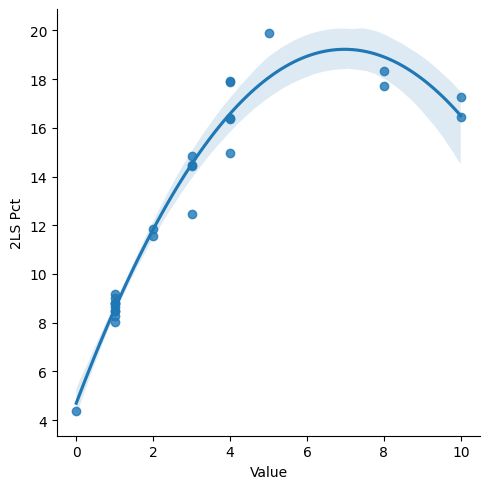

In [13]:
sns.lmplot(data=letter_info, x='Value', y='2LS Pct', order=2)

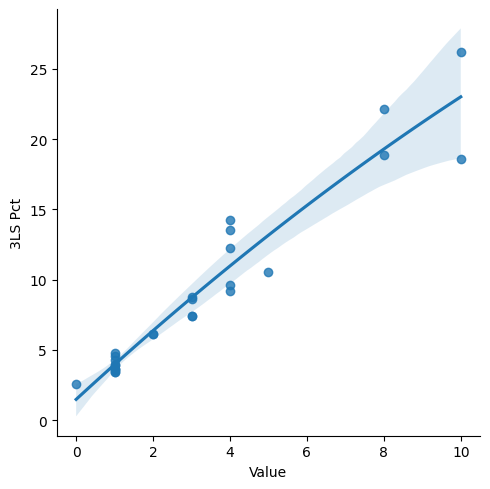

In [14]:
sns.lmplot(data=letter_info, x='Value', y='3LS Pct', order=2)

These graphs show a stark distinction; while there is a clear linear relationship between letter value and triple letter plays (the higher a tile is valued the more likely it is to be played on a 3LS), the first graph shows a  non-linear relationship. In regards to double letter squares, a higher valued tile will be played more often only within the 0-4 point range, while any tile worth more than 4 points has a (basically) equal chance of being played.

### Board Analysis
When it comes to finding the best play, coupling good board placement and the right letters can put you well ahead of your opponent. Below, I have create a visualization of a virtual Scrabble board with a superimposed heatmap showing the most popular squares for select letters.

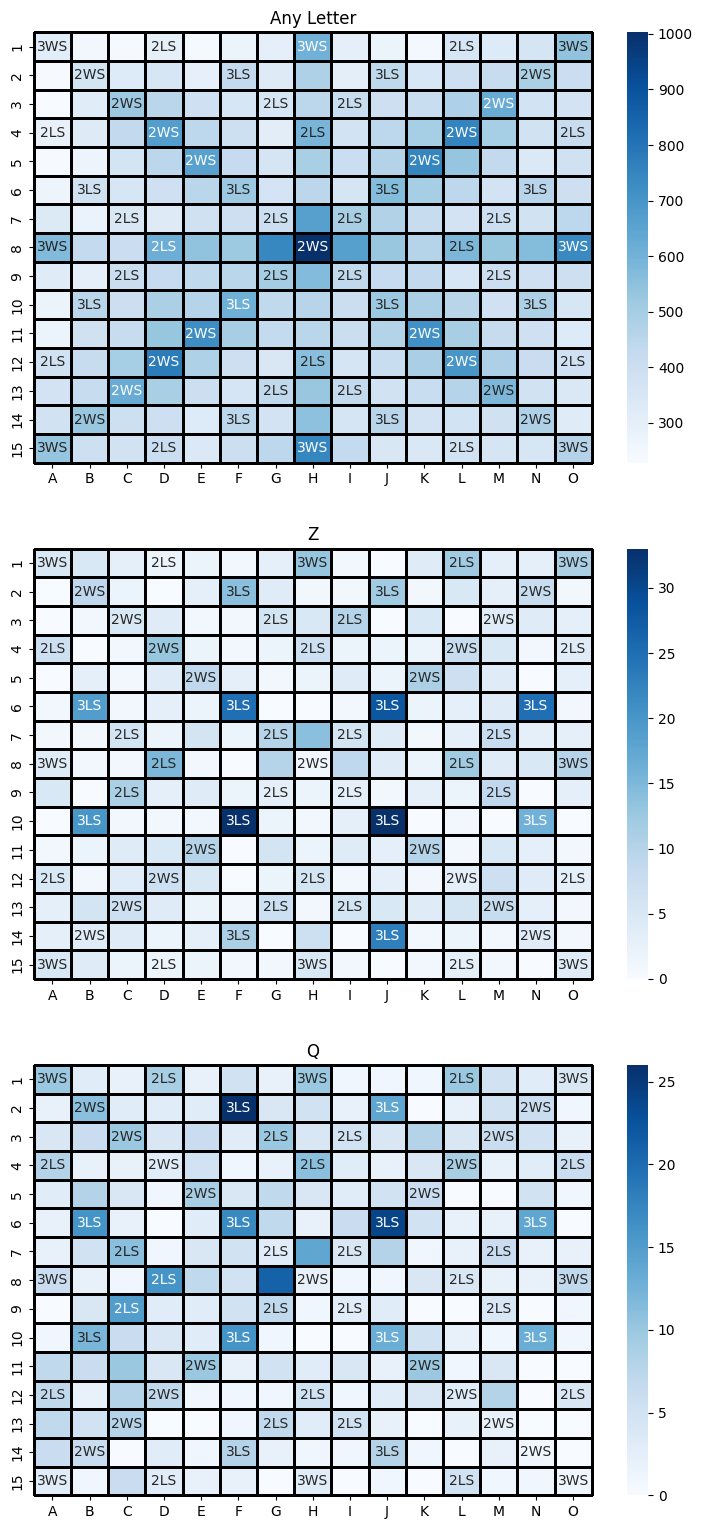

In [15]:
board_numbers = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15']
board_letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O']
board_positions = []
for number in board_numbers:
    for letter in board_letters:
        board_positions.append('{}{}'.format(number, letter))

letters_place_dict = {
    t: pd.DataFrame([[0] * 15] * 15,
                    columns=[l for l in letters[:15]],
                    index=[n + 1 for n in numbers[:-1]])
    for t in playable_tiles
}
letters_place_dict['Any'] = pd.DataFrame([[0] * 15] * 15,
                                         columns=[l for l in letters[:15]],
                                         index=[n + 1 for n in numbers[:-1]])

for i, row in games.iterrows():
    if row['Move']:
        spots = row['New Positions Played']
        tiles = [l for l in row['Move'] if l != '.']
        if spots:
            for tile, spot in zip(tiles, spots):
                for i, position in enumerate(board_positions):
                    if spot == position:
                        spot_num = i
                spot_row = spot_num // 15
                spot_col = spot_num - spot_row * 15
                if tile in letters:
                    letters_place_dict[tile].iloc[spot_row, spot_col] += 1
                    letters_place_dict['Any'].iloc[spot_row, spot_col] += 1
                else:
                    letters_place_dict['Blank'].iloc[spot_row, spot_col] += 1
                    letters_place_dict['Any'].iloc[spot_row, spot_col] += 1

ep_board_spots = pd.DataFrame([[''] * 15] * 15,
                              columns=[l for l in letters[:15]],
                              index=[n + 1 for n in numbers[:-1]])
for s in ['2LS', '3LS', '2WS', '3WS']:
    spots = special_spots[s]
    for spot in spots:
        row = int(spot[:-1])
        col = spot[-1]
        ep_board_spots.at[row, col] = s

fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.set_figheight(19)
fig.set_figwidth(9)

sns.heatmap(letters_place_dict['Any'], cmap='Blues', ax=ax1, linewidths=1, linecolor='black', clip_on=False, annot=ep_board_spots, fmt='')
sns.heatmap(letters_place_dict['Z'], cmap='Blues', ax=ax2, linewidths=1, linecolor='black', clip_on=False, annot=ep_board_spots, fmt='')
sns.heatmap(letters_place_dict['Q'], cmap='Blues', ax=ax3, linewidths=1, linecolor='black', clip_on=False, annot=ep_board_spots, fmt='')

ax1.title.set_text('Any Letter')
ax2.title.set_text('Z')
ax3.title.set_text('Q')

### Word Analysis
Ultimately, perhaps the most important component for succeeding in Scrabble is the size of your vocabulary and your ability to memorize words. However, not all words were created equal in the world of Scrabble. Some words are played much more than others simply because they earn more points or they are more effective in a Scrabble setting.<br>
The following dataset displays the most popular words (more than two letters long) together with the percentage of games they were played in. The ratings are split into two columns - one for the times a word was played as a primary word ('Main Word'), and one including all instances the word was formed ('All Instances').

In [16]:
words_played = {}
words_played_main = {}
for i, row in games.iterrows():
    word = row['Word']
    add_words = row['Additional Words']
    if word:
        if re.match(r'^\w', word):
            if word in words_played:
                words_played[word] += 1
            else:
                words_played[word] = 1
                
            if word in words_played_main:
                words_played_main[word] += 1
            else:
                words_played_main[word] = 1
    if add_words:
        for word in add_words.values():
            word = word.upper()
            if word in words_played:
                words_played[word] += 1
            else:
                words_played[word] = 1
words_played = pd.DataFrame([words_played.keys(), words_played.values()]).transpose()
words_played.columns = ['Word', 'Instances']
words_played_main = pd.DataFrame([words_played_main.keys(), words_played_main.values()]).transpose()
words_played_main.columns = ['Word', 'Instances']
words_played = pd.merge(words_played, words_played_main, how='left', on='Word')
words_played.columns = ['Word', 'All Instances', 'Main Word']
words_played['Main Word'].fillna(0, inplace=True)
words_played['All Instances - Pct of Games'] = words_played['All Instances'] / len(games['Game ID'].unique()) * 100
words_played['All Instances - Pct of Games'] = words_played['All Instances - Pct of Games'].astype(float).round(2)
words_played['Main Word - Pct of Games'] = words_played['Main Word'] / len(games['Game ID'].unique()) * 100
words_played['Main Word - Pct of Games'] = words_played['Main Word - Pct of Games'].astype(float).round(2)
words_played = words_played[['Word', 'All Instances', 'All Instances - Pct of Games', 'Main Word', 'Main Word - Pct of Games']]
words_played.sort_values('All Instances', inplace=True, ascending=False)
words_played.reset_index(inplace=True, drop=True)
words_played[words_played['Word'].str.len() > 2].reset_index(drop=True)[:100]

,Word,All Instances,All Instances - Pct of Games,Main Word,Main Word - Pct of Games
0,QAT,140,13.99,139,13.89
1,QIS,100,9.99,55,5.49
2,QIN,58,5.79,39,3.90
3,EWE,58,5.79,8,0.80
4,AXE,57,5.69,23,2.30
5,OXO,56,5.59,26,2.60
6,ERE,53,5.29,6,0.60
7,ZEE,45,4.50,34,3.40
8,OWE,45,4.50,8,0.80
9,AHI,44,4.40,13,1.30


## Points per Turn 

Displayed below is a visualization of the points earned on each turn.

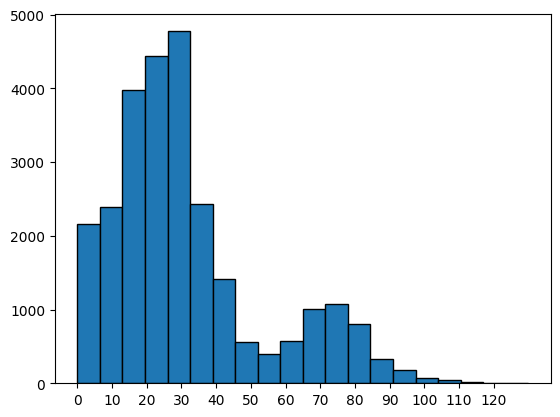

In [17]:
plt.hist(games['Points'], range=(0,130), bins=20, edgecolor='black')
plt.xticks(np.arange(0,130,10))
plt.show()

An overwhelming amount of turns garner between 15 and 30 points, with the highest consentration around 30 points.<br>
Interestingly, there is an additional hump around the 70 point mark. This is due to bingo turns which constitute approximately 14% of plays. The following graphs will illustrate this more clearly:

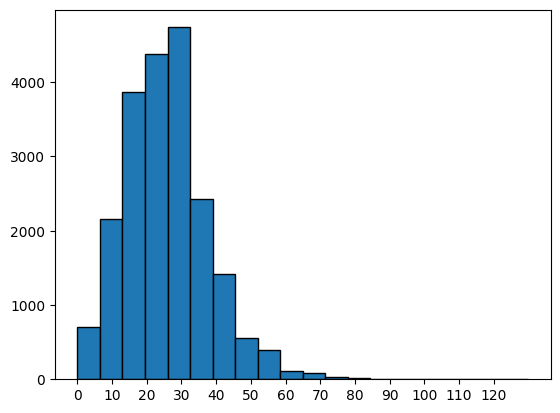

In [18]:
games_non_bingo = games[games['Bingo'] == False]
plt.hist(games_non_bingo['Points'], range=(0,130), bins=20, edgecolor='black')
plt.xticks(np.arange(0,130,10))
plt.show()

Non bingo plays max out at around 80 points.

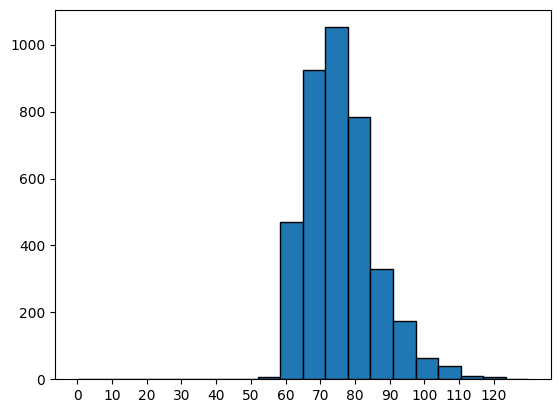

In [19]:
games_bingo = games[games['Bingo'] == True]
plt.hist(games_bingo['Points'], range=(0,130), bins=20, edgecolor='black')
plt.xticks(np.arange(0,130,10))
plt.show()

Due to the additional 50 points earned for bingo plays, most earn around 65-80 points, equivalent to the 15-30 range we saw in non-bingo plays. Bingo plays also max out at 120 points, slightly lower than the 80 point max for non-bingo plays.

## Conclusion
There are many more insights than can be culled from these games, many of which I hope to expand upon in the future. Another interesting resource I have seen in this field is the [analysis](https://rpubs.com/jalapic/scrabblr) done by James P. Curley, which goes through many similar explorations with games simulated on Quackle.<br>
I hope you found this analysis useful and interesting. Feel free to reach out to me with any questions, comments or suggestions.